# <font color='steelblue'> C. Latency to reach the choice point during test runs analysis <font>
### In this notebook I will analyze the latency until choice point during test runs and compare within and across each experimental group and stimulation condition
### If the cingulate cortex is involved in computations leading to the expression of choice, we hypothesize that the latency to choice point in the test illumination condition will be higher in NpHR+ rats when compared to the same condition in NPHR- rats or Non-illuminated periods in both. This increased latency could be a behavioral output of delayed or perturbed choice.
    
### We will also consider the sample illuminated test runs in this analysis, in order to understand whether illuminating the sample run in NpHR+ rats could also lead to latency changes during the following test run, when compared with the Non-illuminated test runs or sample illumination in the NpHR- rats.
    

### <font color='firebrick'> Imports

***

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from file_lists import get_file_list
%matplotlib inline
%run data_prep_functions.ipynb

### <font color='firebrick'> Inputs

***

In [12]:
path = "E:\POSITION DATA\PRE PROCESSED"

### <font color= 'seagreen'> Collect the pruned timestamped position and CP rois from all rats in the given path

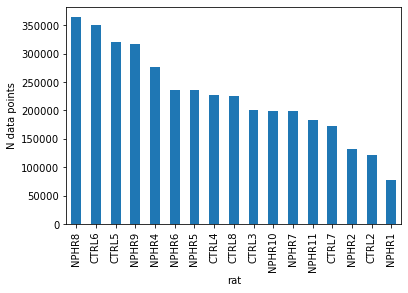

In [13]:
data, rois = collect_pruned_position_and_cp_rois_all_rats_in_path(path)
# Check if data from all rats are present in the dataframe
data['rat'].value_counts().plot.bar()
plt.xlabel('rat')
plt.ylabel('N data points')
plt.show()

### <font color='seagreen'> Collect only the data from test runs

In [14]:
test_runs_raw=data[data['run_type'] == 'T']

### <font color='seagreen'> Get ROI crossing timestamps: start of run, entry in cp, exit of cp

In [15]:
test_runs = get_roi_crossing_timestamps_for_runs_in_df(test_runs_raw, rois)

### <font color= 'seagreen'> Calculate latency to CP entry and exit

In [16]:
test_runs['latency_to_cp_entry'] = test_runs['cp_entry_timestamp'] - test_runs['start_timestamp']
test_runs['latency_to_cp_exit'] = test_runs['cp_exit_timestamp'] - test_runs['start_timestamp']
# Keep only the runs with no illumination and test illumination
pre_test_runs = test_runs[test_runs['stim_condition']== -1]
test_runs = test_runs[(test_runs['stim_condition'] == 0) | (test_runs['stim_condition'] == 3)]
test_runs['stim_condition'].unique()

array([3., 0.])

In [17]:
print(len(test_runs))

4538


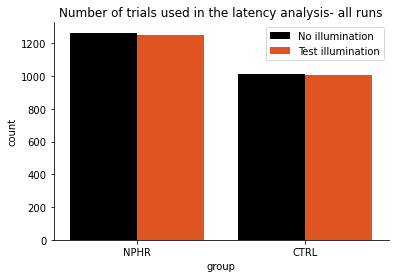

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(data=test_runs, x='group', hue='stim_condition',
             palette=['black', 'orangered'])
plt.legend(
    labels=['No illumination','Test illumination'],
    bbox_to_anchor=(1,1)
)
plt.title("Number of trials used in the latency analysis- all runs")
sns.despine()

In [19]:
test_runs['stim_condition'] =  test_runs['stim_condition'].astype(int).astype(str)
test_runs.groupby(['group', 'stim_condition'])['latency_to_cp_entry'].describe()

count      mean        std       min       25%  \
group stim_condition                                                    
CTRL  0               1012.0  5.204381  11.330262  1.388237  2.116150   
      3               1009.0  5.789922  10.988033  1.518170  2.249331   
NPHR  0               1265.0  4.738188   7.574014  0.991782  2.016154   
      3               1252.0  5.224217   8.643802  1.289830  2.082490   

                           50%       75%         max  
group stim_condition                                  
CTRL  0               2.744774  4.366042  215.430144  
      3               3.075059  4.828493  193.537971  
NPHR  0               2.513370  4.200499  103.747187  
      3               2.679610  4.671482  163.469965

## <font color = 'darkgreen'> 1. Latency until the choice point in all runs (timeouts included) under illumination and no illumination of test runs
***    
### Includes all runs, with all latencies values (outliers were not removed) for all illumination conditions and both groups
***

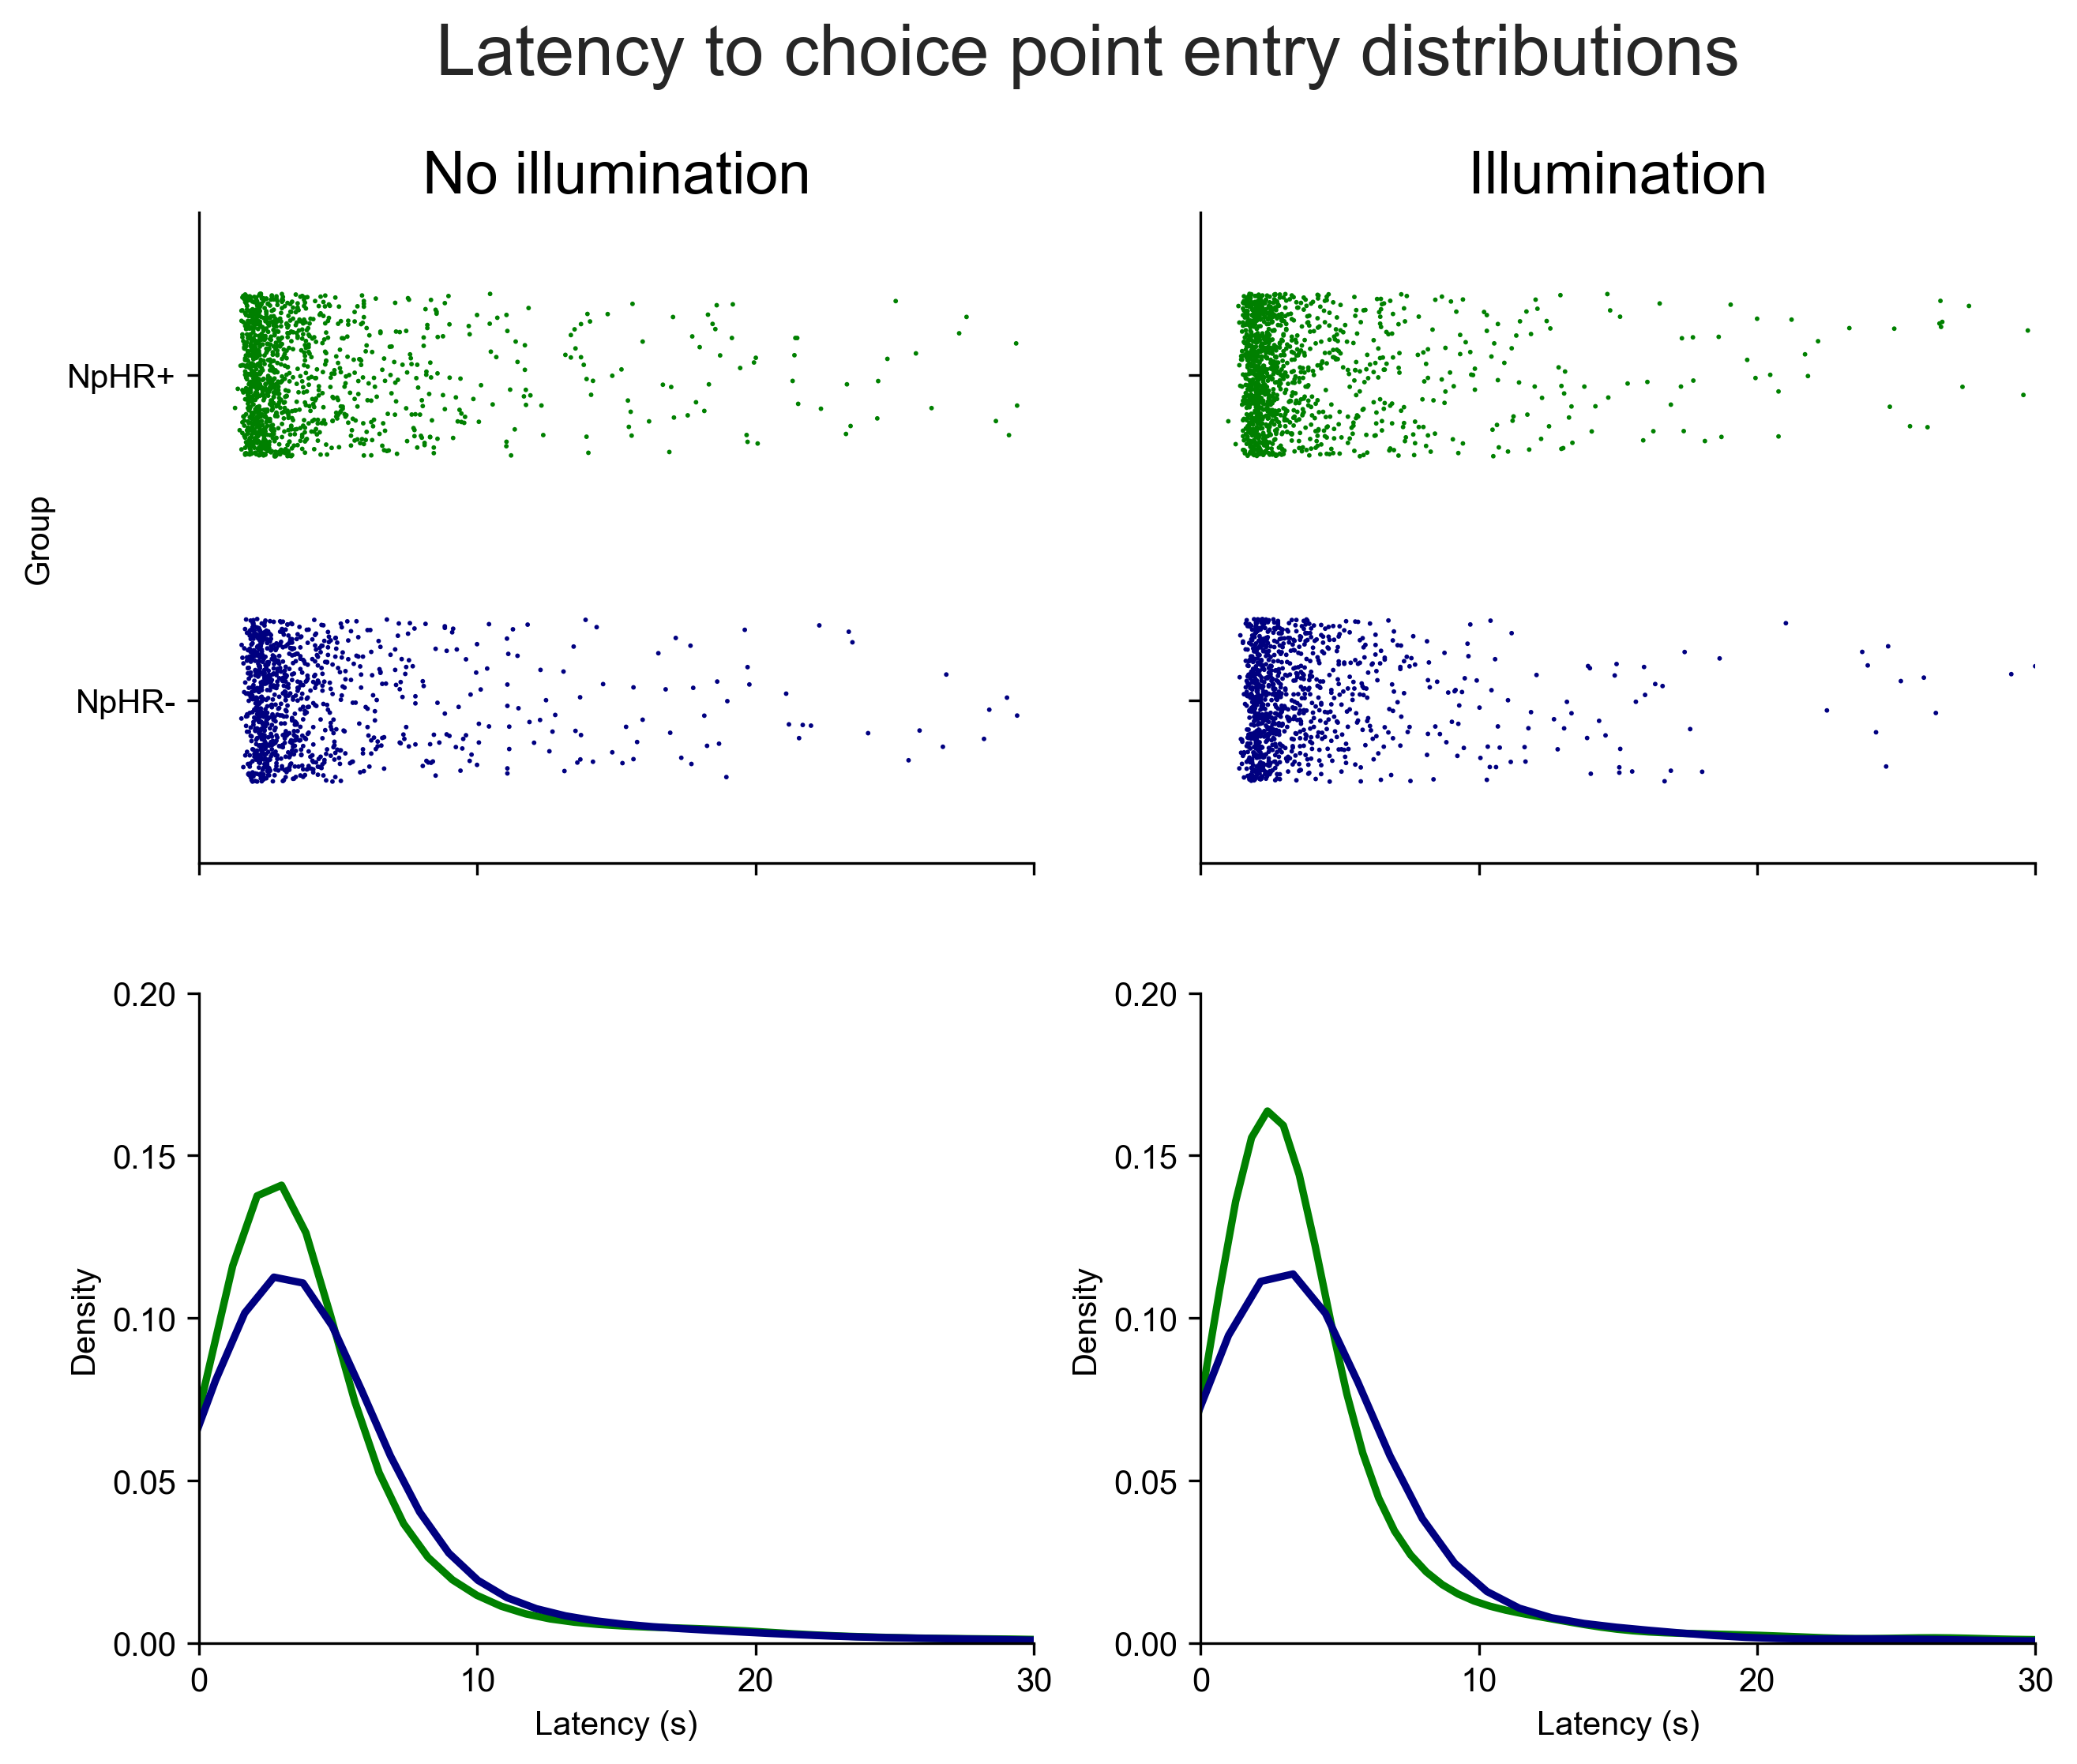

In [20]:
%run data_prep_functions.ipynb
xlim=[0,30]
ylim=[0,.2]
subplot_latency_distributions_within_conditions(test_runs, xlim, ylim)

In [21]:
quantiles = calculate_quantiles(test_runs, ['group', 'stim_condition'], 'latency_to_cp_entry')

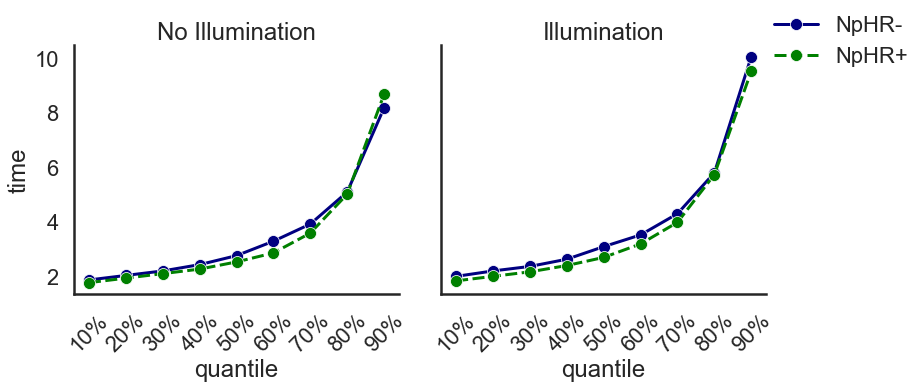

In [22]:
plot_quantile_curves_within_condition(quantiles)

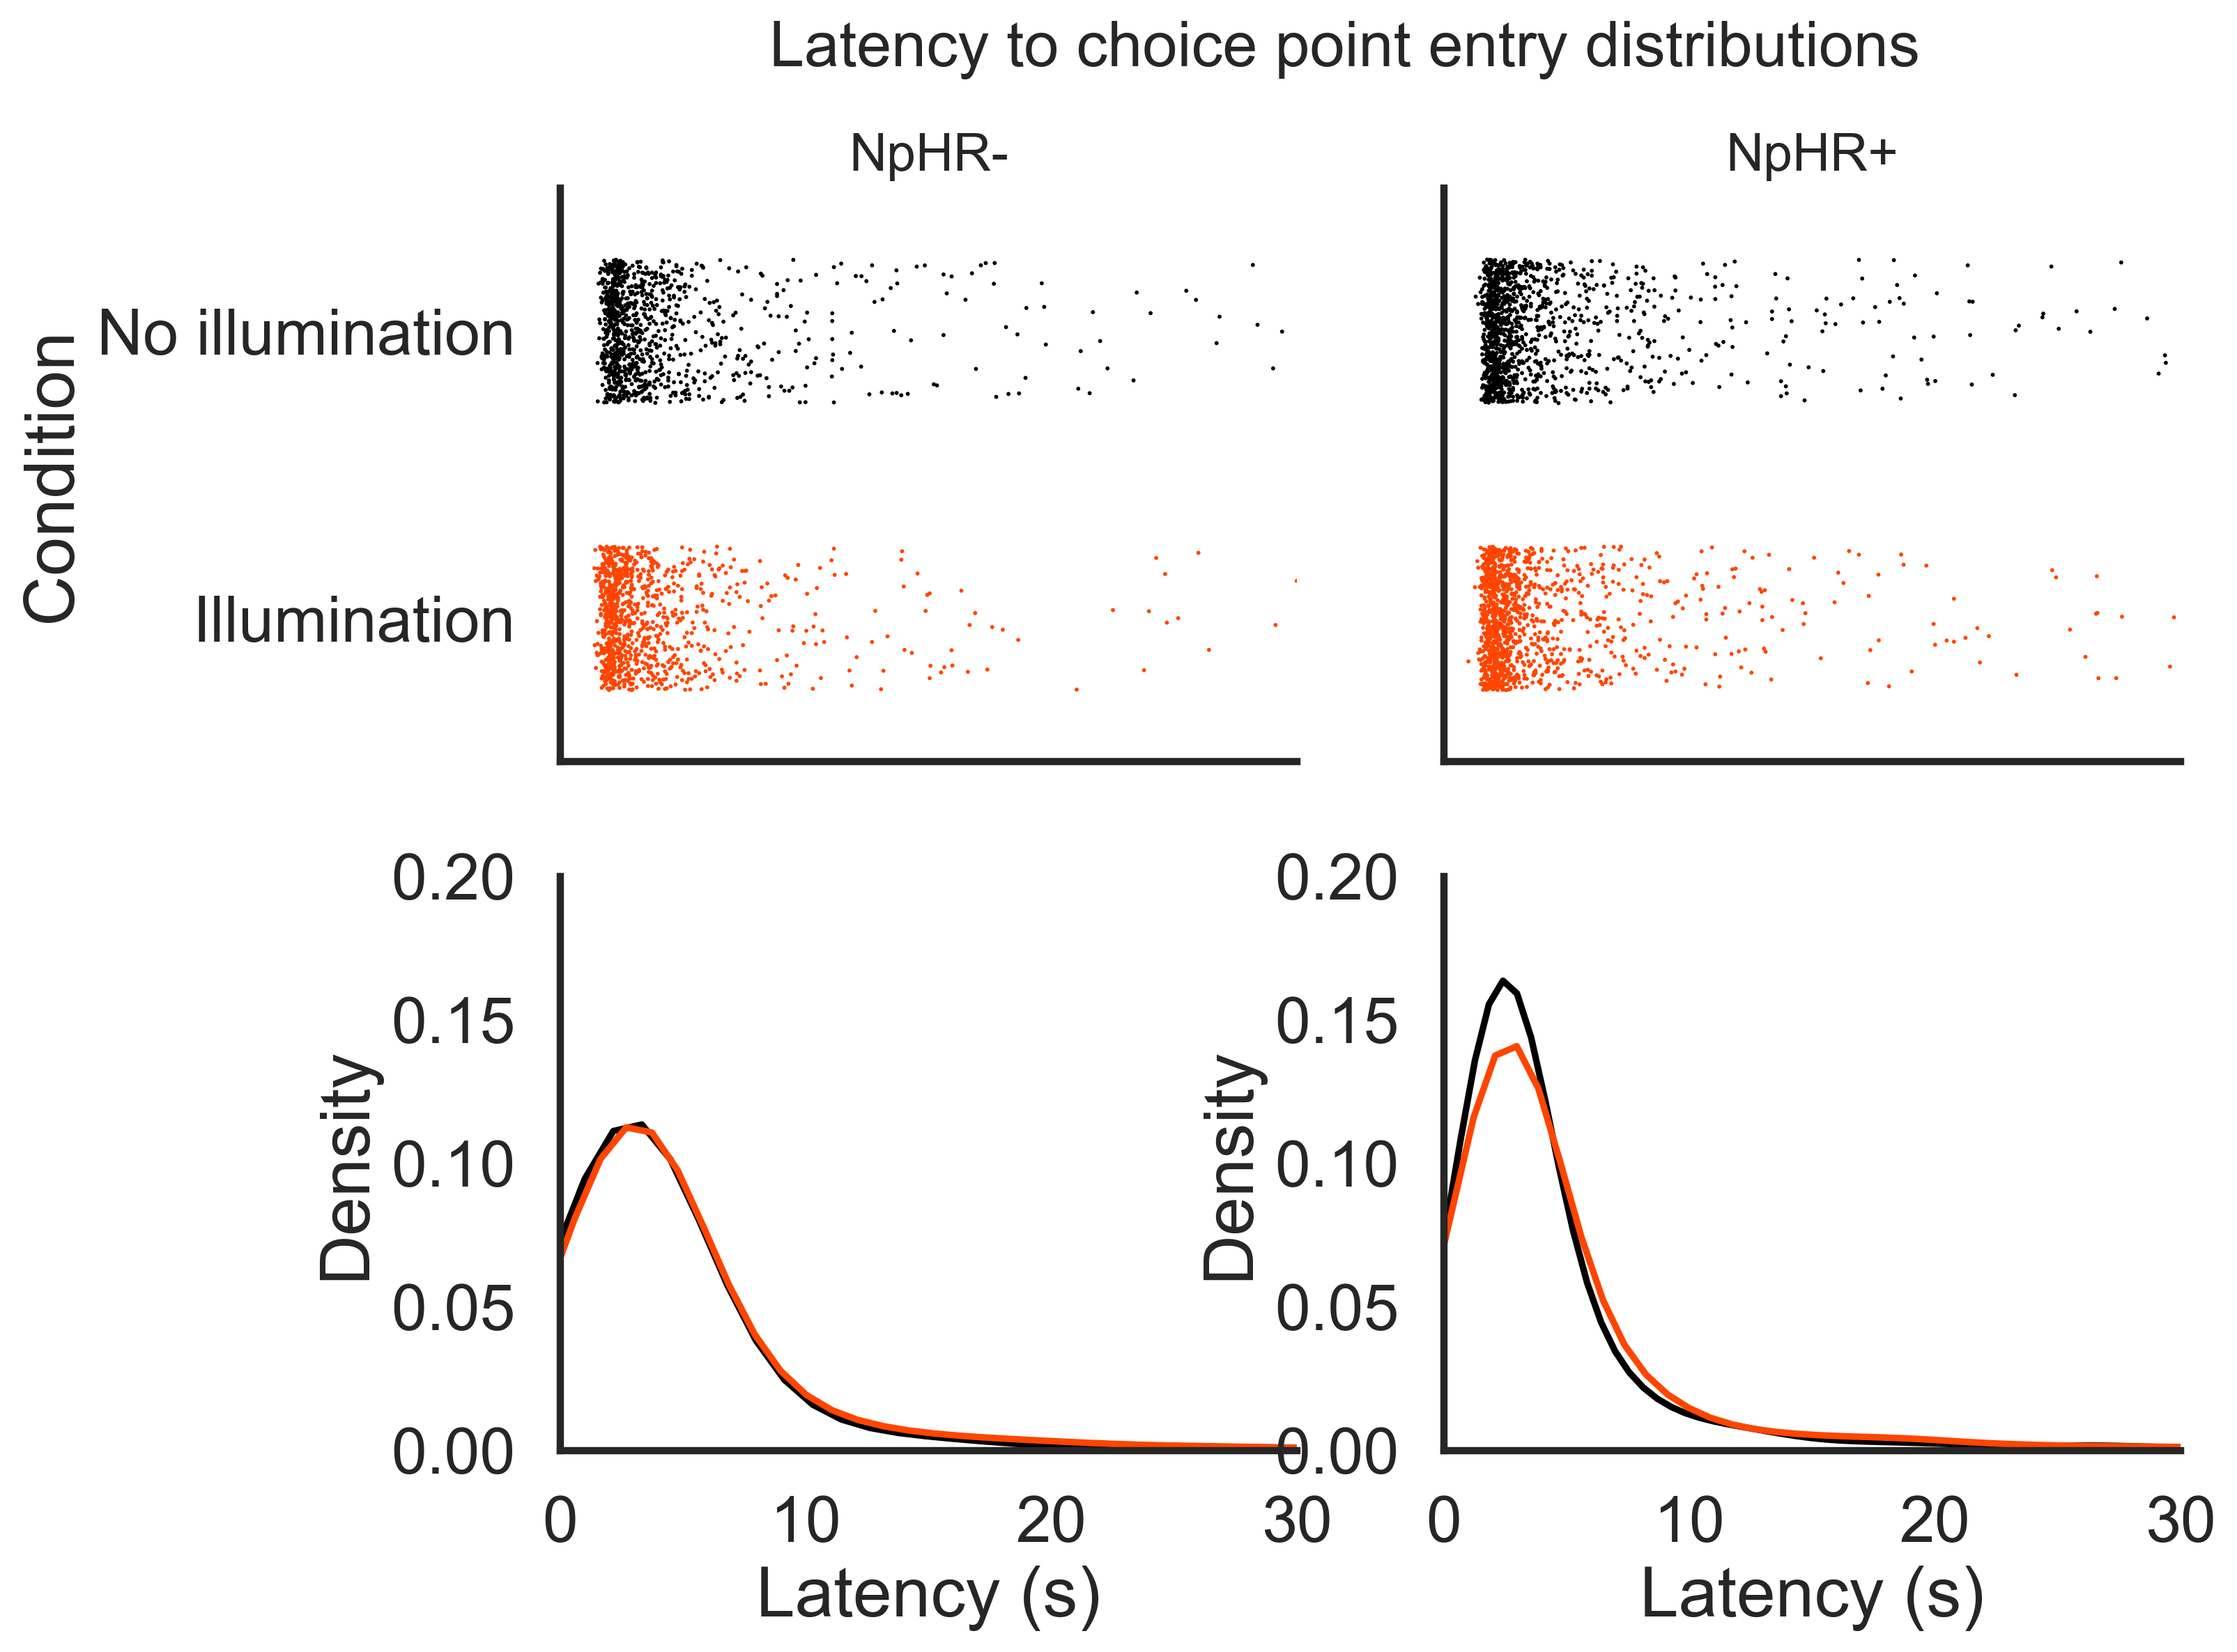

In [23]:
conditions=['0', '3']
xlim=[0,30]
ylim=[0, .2]
subplot_latency_distributions_within_groups(test_runs, conditions, xlim, ylim)

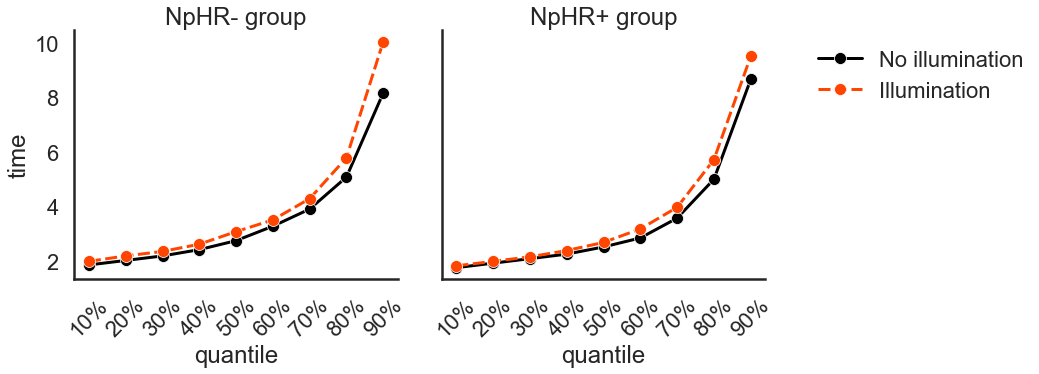

In [24]:
%run data_prep_functions.ipynb
plot_quantile_curves_within_group(quantiles)

#### All latency distributions are right skewed, with the majority of trials having half of the latencies until choice point below 2-3 seconds. However, it is noteworthy the fact that the median latency to CP in NpHR+ rats, during the Pre-illumination period is higher when compared with other conditions. It could be the effect of experience: as rats become more experienced, their latencies decrease. If this was the case, we should see similar effects on the NpHR- group - and we don't. Because the data distribution is highly skewed, I will look at the quantiles of the distributions - namely at their differences. For all the stimulation conditions (0, 3), there is not difference between the NpHR+ and NpHR- groups as they show similar quantile curves.
#### The maximum time of illumination is 15 seconds. When 15 seconds have elapsed from the start of the run, the silencing of the cingulate cortex ends, regardless of where the animal was in the maze. For runs in which the rat did not reach the choice point within this time limit, the silencing of cingulate cortex ended before the choice was expressed and so, it could have contributed for the expression of that choice. As such, we will remove test runs in which the rat did not express its choice before the 15 seconds have elapsed. We will use the choice point square limits as a reference and will collect the session and run nr in which the rat expressed its choice past 15 secs of illumination. We will then filter the currect test runs dataframe (only with position data up to choice point but not inside the CP ROI). Afterwards we will re-compare the latency to choice point distributions.


## <font color = 'darkgreen'> Latencies to choice point distributions without timeouts
    
***   
#### Includes all runs below 15 seconds of latency to cp exit , for all illumination conditions and both groups. 

## <font color='gray'> What is the proportion of timeouts? Are there significant differences in the proportion of timeouts? 

In [25]:
below_15 = test_runs[test_runs['latency_to_cp_exit']<15]

In [320]:
counts = below_15.groupby(['group', 'stim_condition'])['session'].count()
counts

group  stim_condition
CTRL   0                  954
       3                  937
NPHR   0                 1196
       3                 1164
Name: session, dtype: int64

In [27]:
# Calculate the proportion of timeouts per group x rat x condition combination
n_total_runs = test_runs.groupby(['group', 'rat', 'stim_condition']).count()
n_timeout_runs = below_15.groupby(['group', 'rat','stim_condition']).count()
prop_timeouts = ((n_total_runs - n_timeout_runs)/n_total_runs).reset_index()

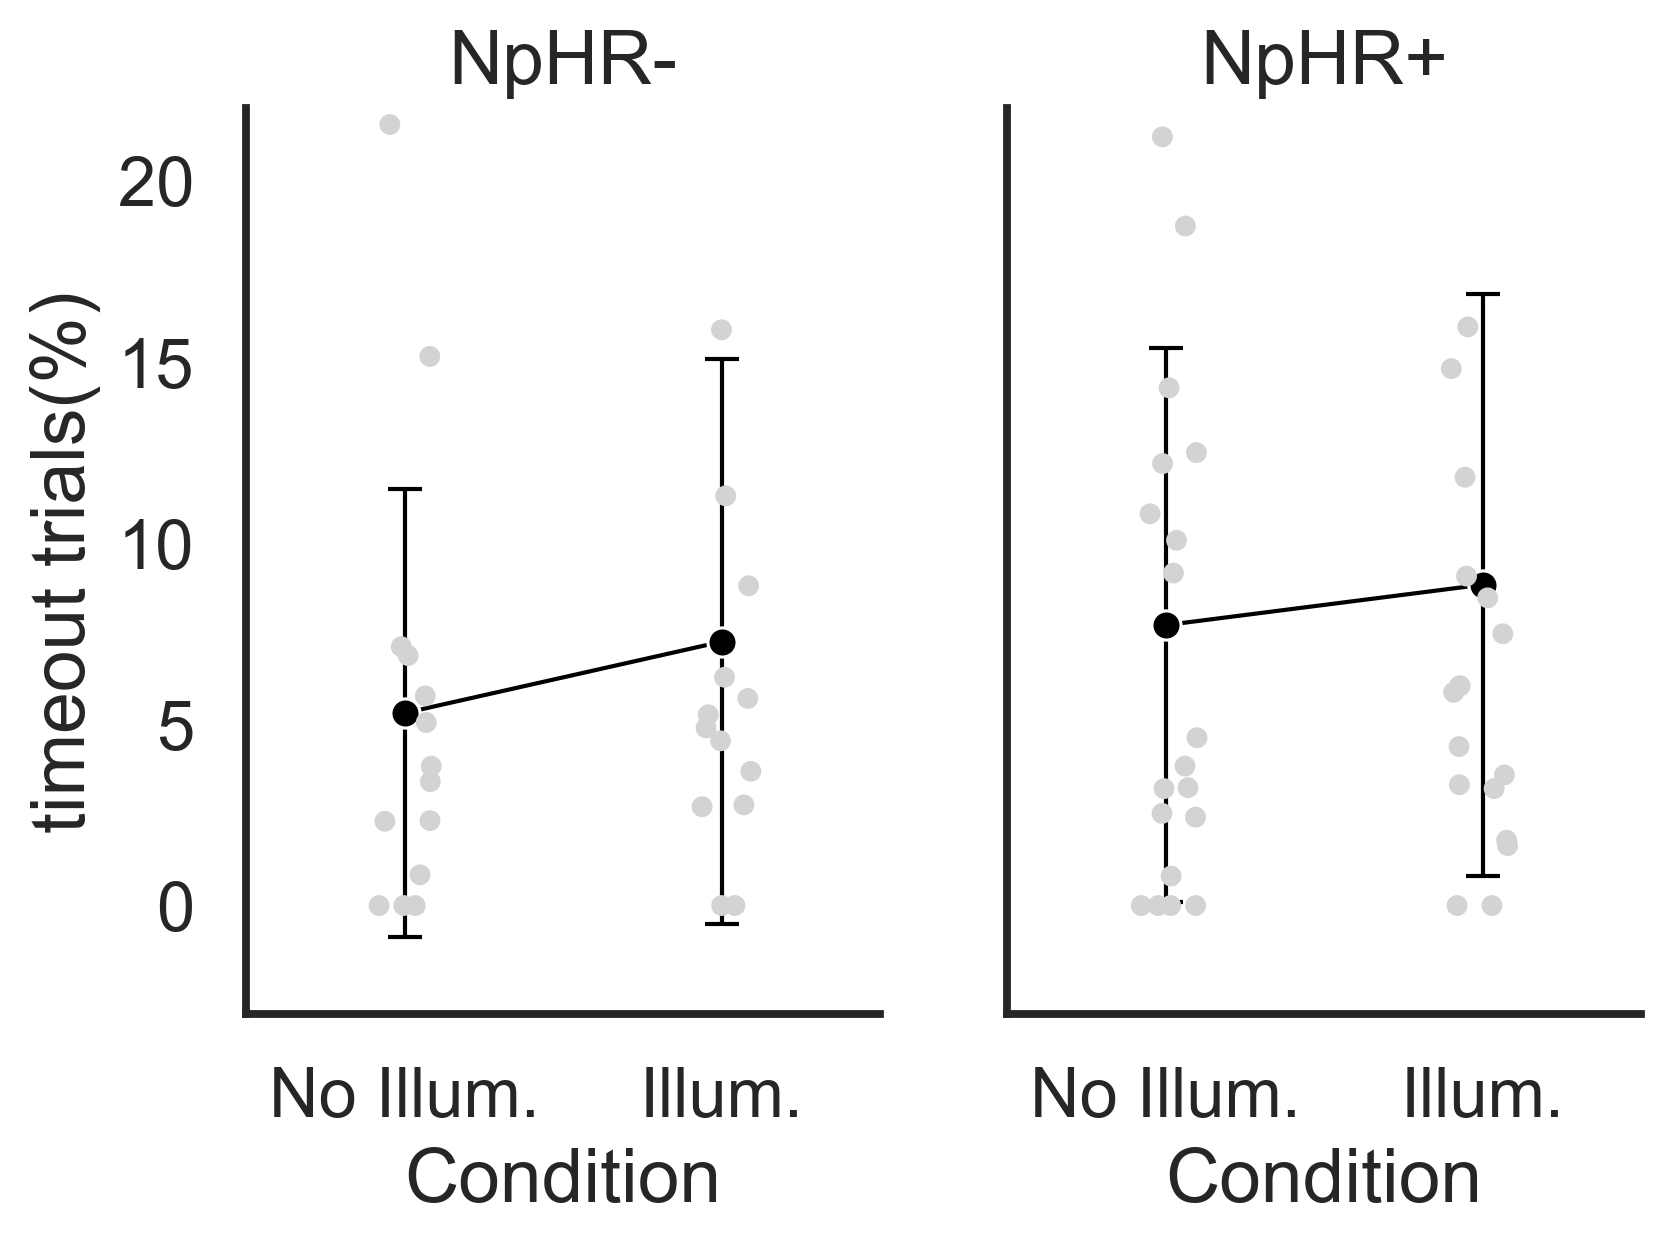

In [59]:
prop_timeouts_nphr=prop_timeouts[prop_timeouts['group']=='NPHR']
prop_timeouts_ctrl=prop_timeouts[prop_timeouts['group']=='CTRL']

#Plot the proportions
fig, axes = plt.subplots(1,2, sharey=True, dpi=300)
sns.set(style='white', context='talk')

sns.stripplot(
    ax=axes[0], data=prop_timeouts_ctrl*100, x='stim_condition', y='run_nr',
    marker='o', size=5, palette=['lightgray'])

sns.stripplot(
    ax=axes[1], data=prop_timeouts_nphr*100, x='stim_condition', y='run_nr', 
    marker='o', size=5, palette=['lightgray'])

sns.lineplot(
    ax=axes[0], data=prop_timeouts_ctrl*100, x='stim_condition', y='run_nr',
    marker='o', markersize=7, alpha=1, linewidth=1,  
    ci='sd', err_style='bars', err_kws={'capsize':4, 'elinewidth':1, 'capthick':1},
    color='black', legend=False
)
sns.lineplot(
    ax=axes[1], data=prop_timeouts_nphr*100, x='stim_condition', y='run_nr',
    marker='o', markersize=7, alpha=1, linewidth=1,
    ci='sd', err_style='bars', err_kws={'capsize':4, 'elinewidth':1, 'capthick':1}, 
    color='black', legend=False, 
)   

axes[0].set(ylim=[-3,22], xlim=[-.5,1.5], 
            xlabel='Condition', ylabel='timeout trials(%)',
            xticklabels=['No Illum.', 'Illum.'],
           title='NpHR-')
axes[1].set(ylim=[-3,22], xlim=[-.5,1.5],
            xlabel='Condition', ylabel='',
            xticklabels=['No Illum.', 'Illum.'],
           title='NpHR+')
sns.despine()

CTRL  0    (0.7587136626243591, 0.015632811933755875)
      3     (0.8473913073539734, 0.11631384491920471)
NPHR  0     (0.9037168622016907, 0.24055694043636322)
      3     (0.8645101189613342, 0.08622530847787857)
dtype: object

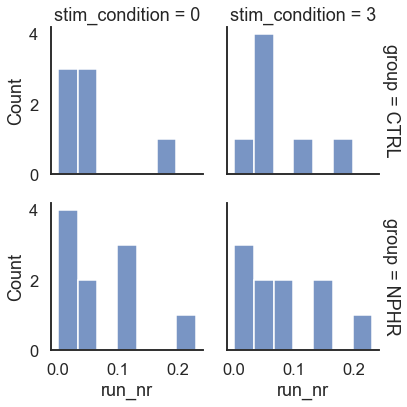

In [29]:
sns.displot(
    prop_timeouts, x="run_nr", col="stim_condition", row="group",
    facet_kws=dict(margin_titles=True), height=3)

from scipy.stats import shapiro
normality_testing = {}
for group, data in prop_timeouts.groupby(['group', 'stim_condition'])['run_nr']:
    stat, p = shapiro(data)
    normality_testing[group] = (stat, p)
normality_testing = pd.Series(normality_testing)
normality_testing

##### For one of the distributions, we rejected the null hypothesis that the distribution could have been withdrawn from a normal distribution. We will used the Wilcoxon test to determine wether the proportion of timeout trials is significantly different in each group (two-sided).

In [30]:
# Wilcoxon test on the NpHR - group
from scipy.stats import wilcoxon
ctrl_no_illum = prop_timeouts_ctrl[prop_timeouts_ctrl['stim_condition']=='0']
ctrl_illum = prop_timeouts_ctrl[prop_timeouts_ctrl['stim_condition']=='3']

w, p = wilcoxon(x=ctrl_no_illum['run_nr'], y=ctrl_illum['run_nr'])
print(w, p)

# Wilcoxon test on the NpHR+ group
nphr_no_illum = prop_timeouts_nphr[prop_timeouts_nphr['stim_condition']=='0']
nphr_illum = prop_timeouts_nphr[prop_timeouts_nphr['stim_condition']=='3']
w, p = wilcoxon(x=nphr_no_illum['run_nr'], y=nphr_illum['run_nr'])
print(w, p)

8.0 0.375
11.0 0.10546875


## <font color='gray'> Latency to Choice point distributions 

In [309]:
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.05, 1.1, f"N = {n}", transform=ax.transAxes)


<Figure size 1800x1200 with 0 Axes>

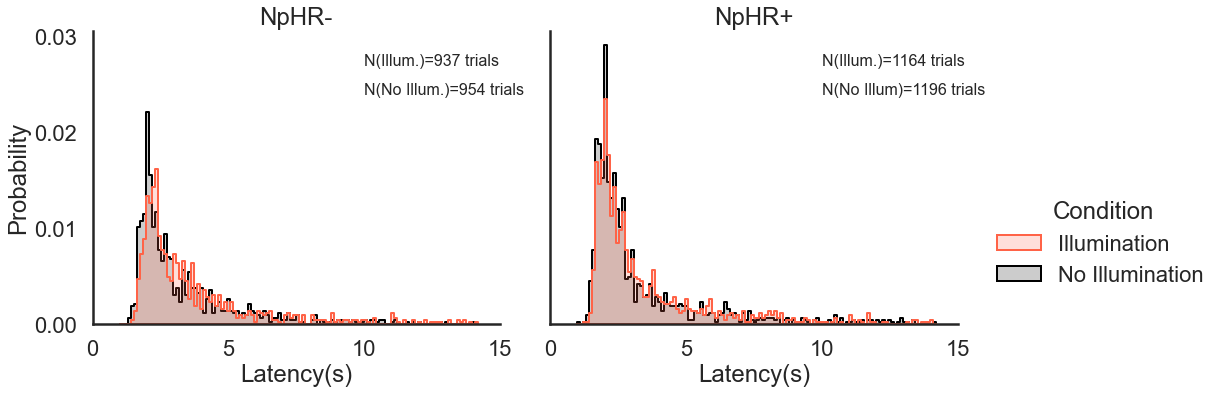

In [423]:
#Plot - each second contains 8 bins
sns.set(style='white', context='poster')
plt.figure(dpi=300)
plt.suptitle('Latency to choice point distributions\n')
g = sns.displot(kind='hist', data=below_15, col='group', 
                x='latency_to_cp_entry', stat='probability', 
                hue=below_15['stim_condition'].map({'0':'No Illumination ', '3':'Illumination'}), 
                col_order=['CTRL', 'NPHR'], element='step', palette=['tomato','black'], 
                bins=120, alpha=.2, height=6, linewidth=2, aspect=1.2)

# subplot specs
axes = g.axes.flatten()
axes[0].set(title="NpHR-", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="NpHR+", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[0].text(10,.027,'N(Illum.)='+str(counts.loc['CTRL','3'])+' trials', fontsize=16)
axes[0].text(10,.024,'N(No Illum.)='+str(counts.loc['CTRL','0'])+' trials', fontsize=16)
axes[1].text(10,.027,'N(Illum.)='+str(counts.loc['NPHR','3'])+' trials', fontsize=16)
axes[1].text(10,.024,'N(No Illum)='+str(counts.loc['NPHR','0'])+' trials', fontsize=16)

#Legend 
g._legend.set(bbox_to_anchor=(.97,.35), title='Condition')
g.tight_layout()
sns.despine()

<Figure size 1800x1200 with 0 Axes>

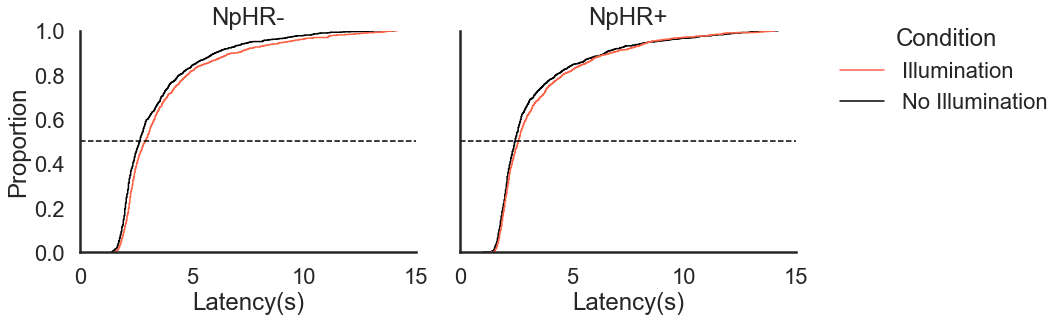

In [424]:
sns.set(style='white', context='poster')
plt.figure(dpi=300)

g = sns.displot(kind='ecdf', data=below_15, col='group', 
            x='latency_to_cp_entry', stat='proportion',
            hue=below_15['stim_condition'].map({'0':'No Illumination ', '3':'Illumination'}),
            col_order=['CTRL','NPHR'], palette=['tomato','black'], height=5, aspect=1.2, linewidth=1.5)
# subplot specs
axes = g.axes.flatten()
axes[0].set(title="NpHR-", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[0].axhline(0.5, 0, 15, linestyle='dashed', c='black', linewidth=1.5)

axes[1].set(title="NpHR+", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].axhline(0.5, 0, 15, linestyle='dashed', c='black', linewidth=1.5)

#Legend 
g._legend.set(bbox_to_anchor=(.98,.7), title='Condition')
g.tight_layout()
sns.despine()

## <font color='gray'> Inference testing on latency to choice point distributions within group

##### The data is clearly not normally distributed, so I will use a non-parametric test (medians).
##### I will be using the Mann-Whitney test to compare the medians of the distributions (has they have a similar shape):
##### H0: the medians of the two groups are equal
##### HA: the medians of the two groups are not equal (two-sided)
##### The data set is dependent - same individuals in two conditions of illumination -  although not paired. For this reason I will not use the Wilcoxon Rank Sum Test. 

In [292]:
# Test No vs. Illumnation in the NpHR- group
from scipy.stats import mannwhitneyu
ctrl_no_illum = below_15[(below_15['stim_condition']=='0') & (below_15['group']=='CTRL')]
ctrl_illum = below_15[(below_15['stim_condition']=='3') & (below_15['group']=='CTRL')]

u, p = mannwhitneyu(x=ctrl_no_illum['latency_to_cp_entry'], y=ctrl_illum['latency_to_cp_entry'])
print(u, p)

397301.5 1.4450818907858461e-05


In [362]:
# Test No vs. Illumnation in the NpHR+ group
from scipy.stats import wilcoxon
nphr_no_illum = below_15[(below_15['stim_condition']=='0') & (below_15['group']=='NPHR')]
nphr_illum = below_15[(below_15['stim_condition']=='3') & (below_15['group']=='NPHR')]

u, p = mannwhitneyu(x=nphr_no_illum['latency_to_cp_entry'], y=nphr_illum['latency_to_cp_entry'])
print(u, p)

647980.0 0.0018314537390134555


<Figure size 1800x1200 with 0 Axes>

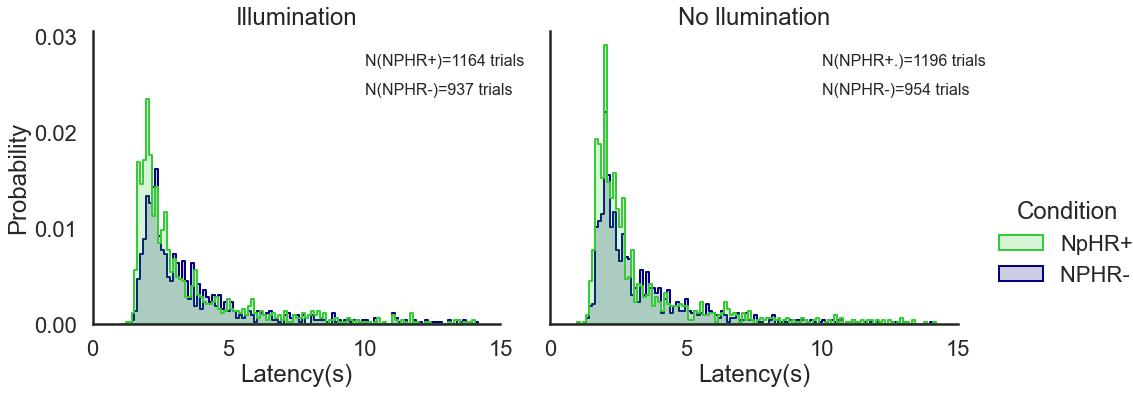

In [392]:
#Plot - each second contains 8 bins
sns.set(style='white', context='poster')
plt.figure(dpi=300)
plt.suptitle('Latency to choice point distributions\n')
g = sns.displot(kind='hist', data=below_15, col='stim_condition', 
                x='latency_to_cp_entry', stat='probability', 
                hue=below_15['group'].map({'CTRL':'NPHR- ', 'NPHR':'NpHR+'}), 
                col_order=['3', '0'], element='step', palette=['limegreen','navy'], 
                bins=120, alpha=.2, height=6, linewidth=2, aspect=1.2)

# subplot specs
axes = g.axes.flatten()
axes[0].set(title="Illumination", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="No llumination", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[0].text(10,.027,'N(NPHR+)='+str(counts.loc['NPHR','3'])+' trials', fontsize=16)
axes[0].text(10,.024,'N(NPHR-)='+str(counts.loc['CTRL','3'])+' trials', fontsize=16)
axes[1].text(10,.027,'N(NPHR+.)='+str(counts.loc['NPHR','0'])+' trials', fontsize=16)
axes[1].text(10,.024,'N(NPHR-)='+str(counts.loc['CTRL','0'])+' trials', fontsize=16)
#Legend 
g._legend.set(bbox_to_anchor=(.97,.35), title='Condition')
g.tight_layout()
sns.despine()

<Figure size 1800x1200 with 0 Axes>

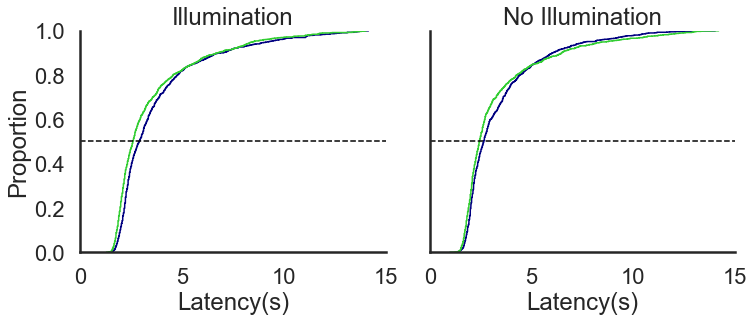

In [394]:
sns.set(style='white', context='poster')
plt.figure(dpi=300)

g = sns.displot(kind='ecdf', data=below_15, col='stim_condition', 
            x='latency_to_cp_entry', stat='proportion',
            hue=below_15['group'].map({'CTRL':'NpHR- ', 'NPHR':'NpHR+'}),
            col_order=['3','0'], palette=['limegreen','navy'], height=5, aspect=1.1, linewidth=1.5, legend=False)
# subplot specs
axes = g.axes.flatten()
axes[0].set(title="Illumination", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[0].axhline(0.5, 0, 15, linestyle='dashed', c='black', linewidth=1.5)

axes[1].set(title="No Illumination", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].axhline(0.5, 0, 15, linestyle='dashed', c='black', linewidth=1.5)

g.tight_layout()
sns.despine()

## <font color='gray'> Inference testing on latency to choice point distributions within conditions

##### The data is clearly not normally distributed, so I will use a non-parametric test (medians).
##### I will be using the Mann-Whitney test to compare the medians of the distributions (has they have a similar shape):
##### H0: the medians of the two groups are equal
##### HA: the medians of the two groups are not equal (two-sided)

In [391]:
# Test NpHR+ and NpHR- in the no illumination condition
from scipy.stats import mannwhitneyu
ctrl_no_illum = below_15[(below_15['stim_condition']=='0') & (below_15['group']=='CTRL')]
nphr_no_illum = below_15[(below_15['stim_condition']=='0') & (below_15['group']=='NPHR')]

u, p = mannwhitneyu(x=ctrl_no_illum['latency_to_cp_entry'], y=nphr_no_illum['latency_to_cp_entry'])
print(u, p)

517494.0 0.00010534787962922157


#### ***
# <font color = 'darkgreen'> Latency until the choice point, given condition, in Test runs, grouped by outcome
***
    
#### Includes only runs with expressed choice before 15 seconds from the start have elapsed. In this step, we will repeat the previous analysis, now subdividing the runs according to outcome(correct vs. incorrect trial).

## <font color='gray'> How many trials are using in this analysis ofr each group, condition and outcome?

In [31]:
# Number of trials per group x illumination condition x outcome
below_15.groupby(['group','stim_condition','outcome'])['session'].count()

group  stim_condition  outcome
CTRL   0               0.0        174
                       1.0        780
       3               0.0        202
                       1.0        735
NPHR   0               0.0        215
                       1.0        981
       3               0.0        256
                       1.0        908
Name: session, dtype: int64

## <font color='gray'>  % timeouts in error trials

In [60]:
# Calculate the proportion of timeouts per group x rat x condition combination
n_total_runs = test_runs.groupby(['group', 'rat', 'stim_condition', 'outcome']).count()
n_timeout_runs = below_15.groupby(['group', 'rat','stim_condition', 'outcome']).count()
prop_timeouts = ((n_total_runs - n_timeout_runs)/n_total_runs).reset_index()
prop_timeout_errors = prop_timeouts[prop_timeouts['outcome']==0]
ctrl_timeout_errors = prop_timeout_errors[prop_timeout_errors['group']=='CTRL']
nphr_timeout_errors = prop_timeout_errors[prop_timeout_errors['group']=='NPHR']

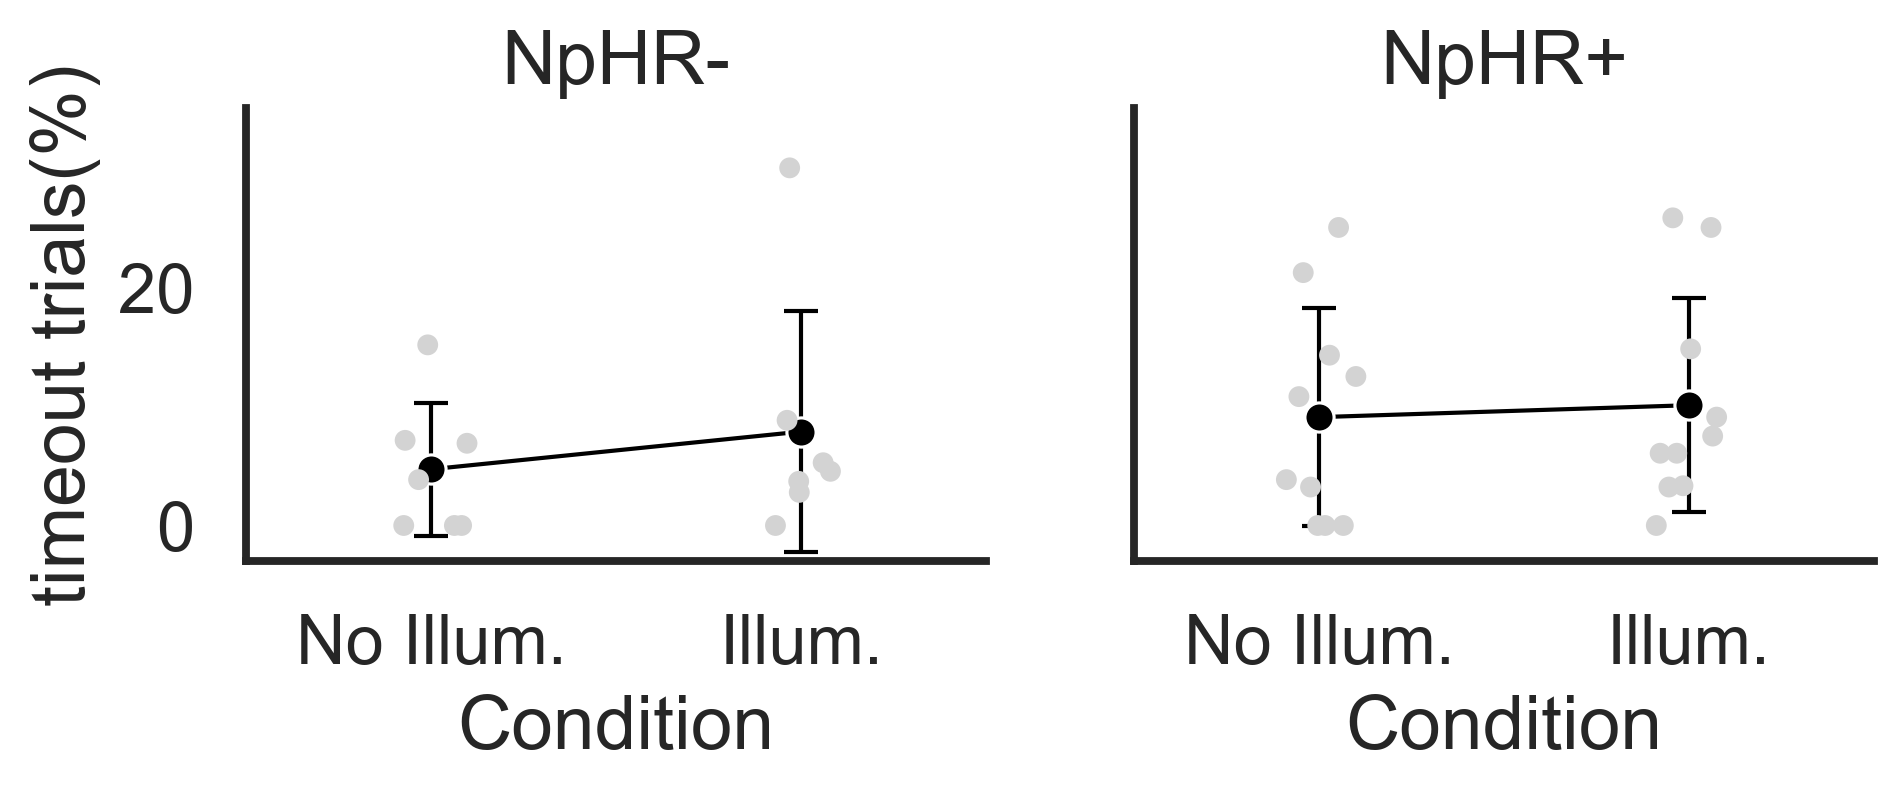

In [61]:

#Plot the proportions
fig, axes = plt.subplots(1,2, figsize=(7,2), sharey=True, dpi=300)
sns.set(style='white', context='talk')

sns.stripplot(
    ax=axes[0], data=ctrl_timeout_errors*100, x='stim_condition', y='run_nr',
    marker='o', size=5, palette=['lightgray'])

sns.stripplot(
    ax=axes[1], data=nphr_timeout_errors*100, x='stim_condition', y='run_nr', 
    marker='o', size=5, palette=['lightgray'])

sns.lineplot(
    ax=axes[0], data=ctrl_timeout_errors*100, x='stim_condition', y='run_nr',
    marker='o', markersize=7, alpha=1, linewidth=1,  
    ci='sd', err_style='bars', err_kws={'capsize':4, 'elinewidth':1, 'capthick':1},
    color='black', legend=False
)
sns.lineplot(
    ax=axes[1], data=nphr_timeout_errors*100, x='stim_condition', y='run_nr',
    marker='o', markersize=7, alpha=1, linewidth=1,
    ci='sd', err_style='bars', err_kws={'capsize':4, 'elinewidth':1, 'capthick':1}, 
    color='black', legend=False, 
)   

axes[0].set(ylim=[-3,35], xlim=[-.5,1.5], 
            xlabel='Condition', ylabel='timeout trials(%)',
            xticklabels=['No Illum.', 'Illum.'],
           title='NpHR-')
axes[1].set(ylim=[-3,35], xlim=[-.5,1.5],
            xlabel='Condition', ylabel='',
            xticklabels=['No Illum.', 'Illum.'],
            title='NpHR+')
sns.despine()

CTRL  0      (0.7946155071258545, 0.00428474647924304)
      3    (0.7691082954406738, 0.0021233183797448874)
NPHR  0     (0.8813312649726868, 0.018696652725338936)
      3     (0.8651072978973389, 0.009649722836911678)
dtype: object

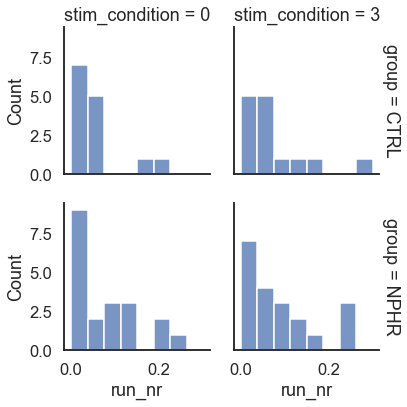

In [62]:
sns.displot(
    prop_timeouts, x="run_nr", col="stim_condition", row="group",
    facet_kws=dict(margin_titles=True), height=3)

from scipy.stats import shapiro
normality_testing = {}
for group, data in prop_timeouts.groupby(['group', 'stim_condition'])['run_nr']:
    stat, p = shapiro(data)
    normality_testing[group] = (stat, p)
normality_testing = pd.Series(normality_testing)
normality_testing

In [63]:
# Wilcoxon test on the NpHR - group
from scipy.stats import wilcoxon
ctrl_no_illum = ctrl_timeout_errors[ctrl_timeout_errors['stim_condition']=='0']
ctrl_illum = ctrl_timeout_errors[ctrl_timeout_errors['stim_condition']=='3']

w, p = wilcoxon(x=ctrl_no_illum['run_nr'], y=ctrl_illum['run_nr'])
print(w, p)

# Wilcoxon test on the NpHR+ group
nphr_no_illum = nphr_timeout_errors[nphr_timeout_errors['stim_condition']=='0']
nphr_illum = nphr_timeout_errors[nphr_timeout_errors['stim_condition']=='3']
w, p = wilcoxon(x=nphr_no_illum['run_nr'], y=nphr_illum['run_nr'])
print(w, p)

11.0 0.6875
9.0 0.39802471950693785


C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [64]:
errors=below_15[below_15['outcome']==0]
nphr_errors = errors[errors['group']=='NPHR']
ctrl_errors=errors[errors['group']=='CTRL']
nphr_errors.head(3)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_entry,latency_to_cp_exit,session_nr
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,3.781990,4.815962,0.0
19,2019-08-09T11_26_15,NPHR1,22.0,1301.300608,T,3,0.0,NPHR,1303.369702,1304.408230,2.069094,3.107622,NaN
27,2019-08-09T11_26_15,NPHR1,40.0,2385.598310,T,3,0.0,NPHR,2388.177114,2388.857050,2.578803,3.258739,NaN


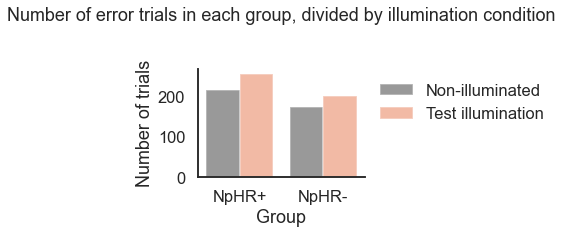

In [93]:
plt.figure(figsize=(3,2))
sns.countplot(data=errors, x='group', hue='stim_condition', hue_order=['0', '3'],
             palette=['Black', 'orangered'], alpha=.4)
plt.legend(
    labels=['Non-illuminated', 'Test illumination'],
    bbox_to_anchor=(1,1),
    frameon=False
)
plt.xlabel('Group')
plt.ylabel('Number of trials')
plt.title("Number of error trials in each group, divided by illumination condition\n\n")
plt.xticks(ticks=[0,1], labels=['NpHR+', 'NpHR-'])
sns.despine()

##### The distribution of errors within condition and group is very similar.

## <font color='gray'> Latency to Choice point distributions

<Figure size 432x288 with 0 Axes>

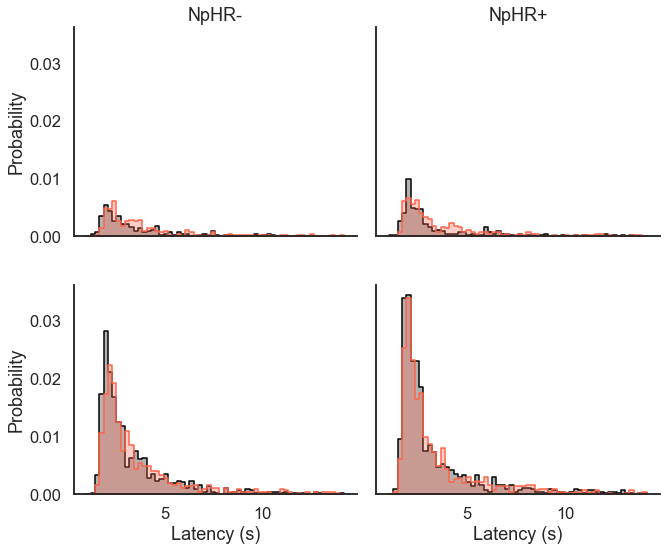

In [421]:
sns.set(style='white', context='talk')
plt.suptitle('Latency to choice point distributions\n')
g = sns.displot(kind='hist', data=below_15, col='group', row='outcome', x='latency_to_cp_entry',
            stat='probability', hue='stim_condition', col_order=['CTRL', 'NPHR'],element='step',
                palette=['tomato','black'], bins=60, alpha=.3, legend=False, height=4, aspect=1.2)

axes = g.axes.flatten()
axes[0].set(title="NpHR-")
axes[1].set(title="NpHR+")
axes[2].set(title="", xlabel='Latency (s)')
axes[3].set(title="", xlabel='Latency (s)')
sns.despine()

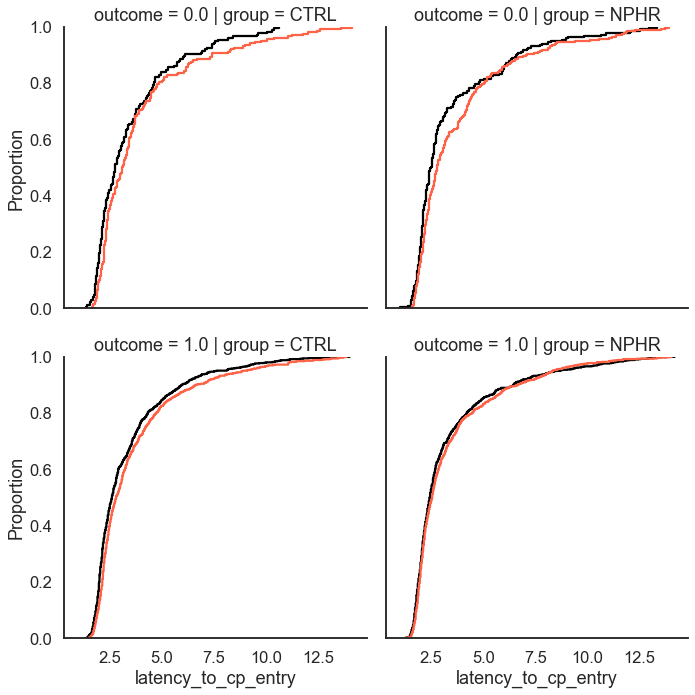

In [422]:
sns.displot(kind='ecdf', data=below_15, col='group', row='outcome', x='latency_to_cp_entry',
            stat='proportion', hue='stim_condition', col_order=['CTRL', 'NPHR'],
                palette=['tomato','black'], legend=False)

In [40]:
from scipy.stats import mannwhitneyu, kstest

# Using the Mann-Whitney test to compare medians in the NPHR+ group
nphr_errors_no = nphr_errors[nphr_errors['stim_condition']=='0']
nphr_errors_illum = nphr_errors[nphr_errors['stim_condition']=='3']

u, p = mannwhitneyu(x=nphr_errors_no['latency_to_cp_entry'], 
                    y=nphr_errors_illum['latency_to_cp_entry'], 
                    alternative='two-sided')

print('NPHR+, Mann-Whitney result, test stat: '+str(u)+', p-value: '+str(p))

# Using the KS test to compare the cumulative distributions
w,p = kstest(nphr_errors_no['latency_to_cp_entry'], nphr_errors_illum['latency_to_cp_entry'],
             alternative='two-sided')
print('NPHR+, KS result, test stat: '+str(w)+', p-value: '+str(p))

# Using the Mann-Whitney test to compare medians in the NPHR- group
ctrl_errors_no = ctrl_errors[ctrl_errors['stim_condition']=='0']
ctrl_errors_illum = ctrl_errors[ctrl_errors['stim_condition']=='3']

u, p = mannwhitneyu(x=ctrl_errors_no['latency_to_cp_entry'], 
                    y=ctrl_errors_illum['latency_to_cp_entry'], 
                    alternative='two-sided')

print('NPHR-, Mann-Whitney result, test stat: '+str(u)+', p-value: '+str(p))

# Using the KS test to compare the cumulative distributions
w,p = kstest(ctrl_errors_no['latency_to_cp_entry'], ctrl_errors_illum['latency_to_cp_entry'],
             alternative='two-sided')
print('NPHR-, KS result, test stat: '+str(w)+', p-value: '+str(p))

NPHR+, Mann-Whitney result, test stat: 23880.5, p-value: 0.013390223630526655
NPHR+, KS result, test stat: 0.13497456395348836, p-value: 0.02502681608524071
NPHR-, Mann-Whitney result, test stat: 15324.0, p-value: 0.03229829738914687
NPHR-, KS result, test stat: 0.14697849095254353, p-value: 0.030827681694501452


<Figure size 432x288 with 0 Axes>

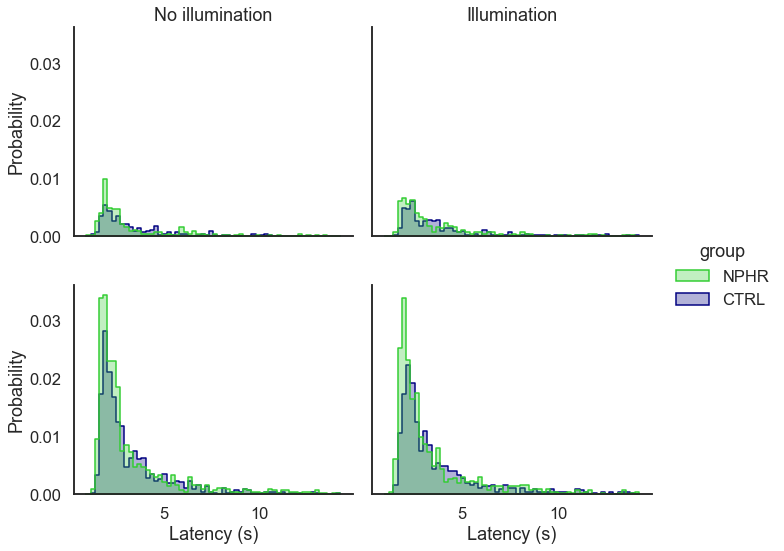

In [118]:
sns.set(style='white', context='talk')
plt.suptitle('Latency to choice point distributions\n')
g = sns.displot(kind='hist', data=below_15, col='stim_condition', row='outcome', x='latency_to_cp_entry',
            stat='probability', hue='group', col_order=['0', '3'], element='step',
                palette=['limegreen','navy'], bins=60, alpha=.3, height=4, aspect=1.2)

axes = g.axes.flatten()
axes[0].set(title="No illumination")
axes[1].set(title="Illumination")
axes[2].set(title="", xlabel='Latency (s)')
axes[3].set(title="", xlabel='Latency (s)')
sns.despine()

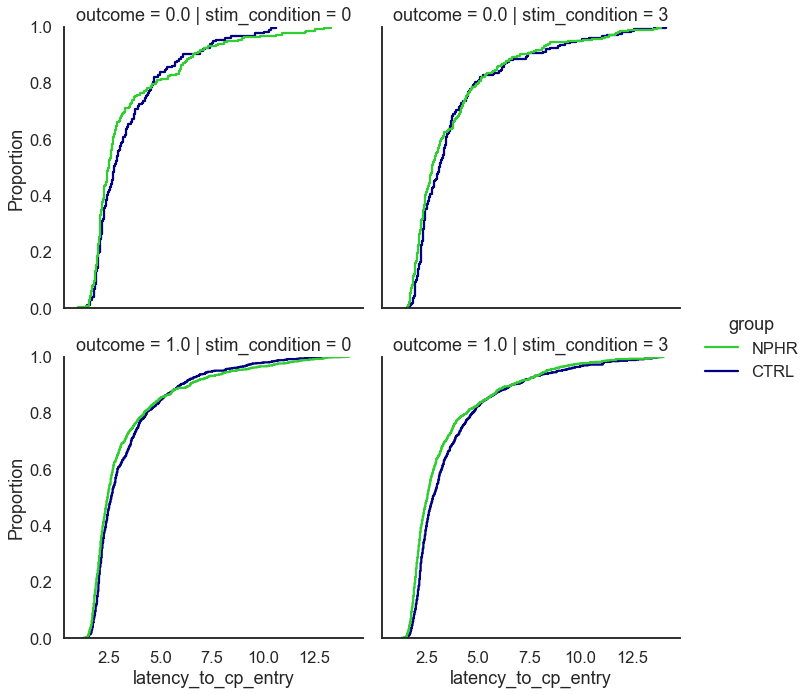

In [113]:
sns.displot(kind='ecdf', data=below_15, col='stim_condition', row='outcome', x='latency_to_cp_entry',
            stat='proportion', hue='group', col_order=['0', '3'],
                palette=['limegreen','navy'])

## <font color='darkgreen'> 3. Median Latency across sessions

In [48]:
median_latencies = below_15.groupby(['group', 'rat','stim_condition','session'])['latency_to_cp_entry'].apply(np.median)
median_latencies = median_latencies.reset_index()
def add_session_nr(group):
    group['session_nr']=range(1,len(group)+1)
    return group

median_latencies= median_latencies.groupby(['group', 'rat', 'stim_condition']).apply(
                                    add_session_nr).reset_index()
median_latencies

,index,group,rat,stim_condition,session,latency_to_cp_entry,session_nr
0,0,CTRL,CTRL2,0,2020-02-07T14_40_27,3.637888,1
1,1,CTRL,CTRL2,0,2020-02-08T10_24_17,1.854938,2
2,2,CTRL,CTRL2,0,2020-02-09T10_17_11,1.914150,3
3,3,CTRL,CTRL2,0,2020-02-10T10_40_34,1.745843,4
4,4,CTRL,CTRL2,0,2020-02-10T15_02_42,2.049408,5
...,...,...,...,...,...,...,...
483,483,NPHR,NPHR9,3,2020-12-03T15_29_16,2.728710,11
484,484,NPHR,NPHR9,3,2020-12-04T12_44_55,2.545549,12
485,485,NPHR,NPHR9,3,2020-12-07T12_44_10,2.579405,13
486,486,NPHR,NPHR9,3,2020-12-08T14_51_38,3.472717,14


<Figure size 3600x2400 with 0 Axes>

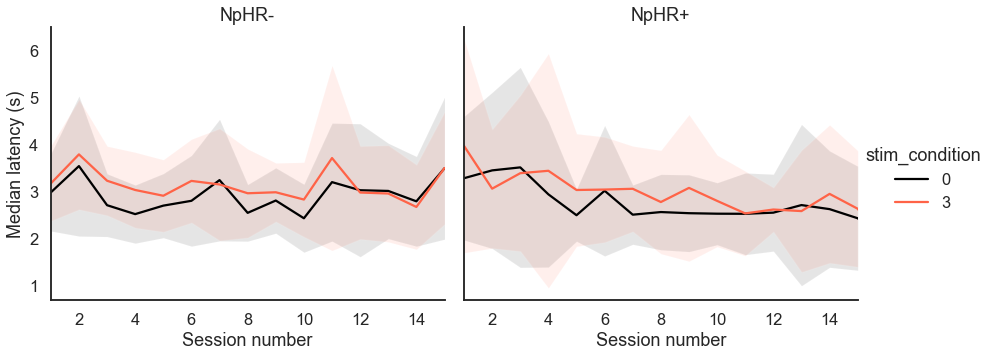

In [420]:
plt.figure(figsize=(12,8), dpi=300)
sns.set(style='white', context='talk')
g = sns.relplot(kind='line', data=median_latencies, col='group', 
                x='session_nr', y='latency_to_cp_entry', hue='stim_condition',
                ci='sd', height=5, aspect=1.2, palette=['black', 'tomato'],
                err_kws={'linewidth': None, 'edgecolor':None,'alpha':.1})
                               
axes = g.axes.flatten()
axes[0].set(title="NpHR-", ylabel= 'Median latency (s)', xlabel='Session number', xlim=[1,15])
axes[1].set(title="NpHR+", ylabel= 'Median latency (s)', xlabel='Session number')
sns.despine()

<Figure size 3600x2400 with 0 Axes>

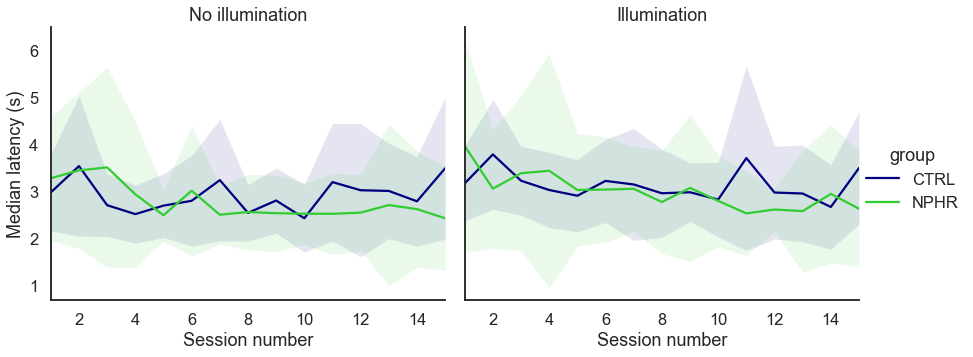

In [416]:
plt.figure(figsize=(12,8), dpi=300)
sns.set(style='white', context='talk')
g = sns.relplot(kind='line', data=median_latencies, col='stim_condition', 
                x='session_nr', y='latency_to_cp_entry', hue='group',
                ci='sd', height=5, aspect=1.2, palette=['navy', 'limegreen'],
                err_kws={'linewidth': None, 'edgecolor':None,'alpha':.1})
                               
axes = g.axes.flatten()
axes[0].set(title="No illumination", ylabel= 'Median latency (s)', xlabel='Session number', xlim=[1,15])
axes[1].set(title="Illumination", ylabel= 'Median latency (s)', xlabel='Session number')
sns.despine()

In [50]:
first_sessions = below_15.groupby(['group', 'rat'])['session'].head(1).tolist()
final_sessions = below_15.groupby(['group','rat'])['session'].tail(1).tolist()

In [51]:
below_15.loc[:,'session_nr']=np.NaN

for l, nr in zip([first_sessions, final_sessions], [0,1]):
    mask = below_15['session'].isin(l)
    below_15.loc[mask, 'session_nr']=nr

C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [55]:
below_15.groupby(['group', 'stim_condition','session_nr']).count()

session  rat  run_nr  start_timestamp  \
group stim_condition session_nr                                          
CTRL  0              0.0              67   67      67               67   
                     1.0              66   66      66               66   
      3              0.0              65   65      65               65   
                     1.0              61   61      61               61   
NPHR  0              0.0              84   84      84               84   
                     1.0              82   82      82               82   
      3              0.0              75   75      75               75   
                     1.0              79   79      79               79   

                                 run_type  outcome  cp_entry_timestamp  \
group stim_condition session_nr                                          
CTRL  0              0.0               67       67                  67   
                     1.0               66       66                  66   
      3              0.0               65       65                  65   
                     1.0               61       61                  61   
NPHR  0              0.0               84       84                  84   
                     1.0               82       82                  82   
      3              0.0               75       75                  75   
                     1.0               79       79                  79   

                                 cp_exit_timestamp  latency_to_cp_entry  \
group stim_condition session_nr                                           
CTRL  0              0.0                        67                   67   
                     1.0                        66                   66   
      3              0.0                        65                   65   
                     1.0                        61                   61   
NPHR  0              0.0                        84                   84   
                     1.0                        82                   82   
      3              0.0                        75                   75   
                     1.0                        79                   79   

                                 latency_to_cp_exit  
group stim_condition session_nr                      
CTRL  0              0.0                         67  
                     1.0                         66  
      3              0.0                         65  
                     1.0                         61  
NPHR  0              0.0                         84  
                     1.0                         82  
      3              0.0                         75  
                     1.0                         79

### Comparing first and last session distributions - try doing first 3, last 3

<Figure size 864x576 with 0 Axes>

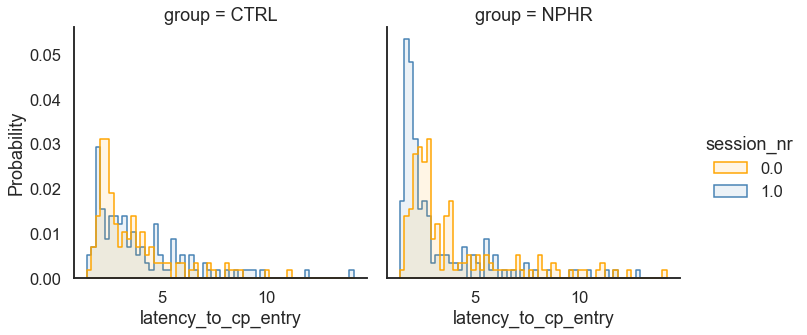

In [425]:
illumination = below_15[below_15['stim_condition']=='3']
below_15.copy().dropna(inplace=True)
sns.set(style='white', context='talk')
plt.figure(figsize=(12,8))
plt.suptitle('Comparing first and last session')
g = sns.displot(kind='hist', data=below_15, col='group', x='latency_to_cp_entry',
            stat='probability', hue='session_nr', col_order=['CTRL', 'NPHR'],element='step',
            palette=['orange','steelblue'], bins=60, alpha=.1)

#axes = g.axes.flatten()
#axes[0].set(title="NpHR-", xlabel= 'Latency (s)')
#axes[1].set(title="NpHR+", xlabel= 'Latency (s)')
sns.despine()

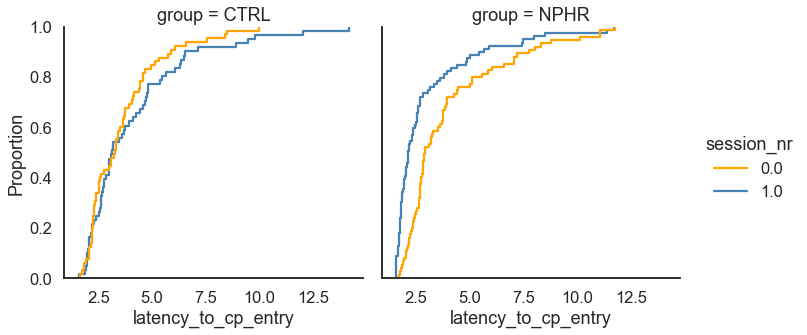

In [428]:
sns.displot(kind='ecdf', data=illumination, col='group', x='latency_to_cp_entry',
            stat='proportion', hue='session_nr', col_order=['CTRL', 'NPHR'],
                palette=['orange','steelblue'])

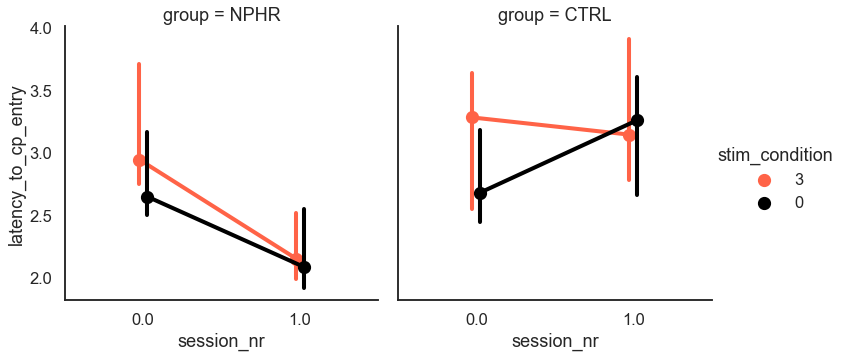

In [436]:
sns.catplot(kind='point', col='group', data=below_15, x='session_nr', 
           y='latency_to_cp_entry', hue='stim_condition', estimator=np.median, n_boots=1000,
           palette=['tomato','black'], dodge=True)